# 使用 `skimage` 进行图像处理

这个例子构建了一个简单的用户界面，用于使用 [scikit-image](http://scikit-image.org/) 进行基本的图像处理。

In [1]:
# Imports for JupyterLite
%pip install -q ipywidgets scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Stdlib imports
from io import BytesIO

# Third-party libraries
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import matplotlib as mpl
import matplotlib.image
from skimage import data, filters, io, img_as_float
import numpy as np

让我们从 `scikit-image` 的 `data` 模块中加载一张图片。这些图片以常规的 numpy 数组形式返回：

In [3]:
i = img_as_float(data.coffee())
i.shape

(400, 600, 3)

编写实用函数，用于通过 IPython 显示协议展示 Numpy 数组：

In [4]:
def arr2img(arr):
    """将2维或3维的numpy数组显示为图像。"""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("只有2维或3维数组才能被显示为图像。")
    # 不要让 `matplotlib` 自动缩放颜色范围，这样我们就可以控制整体亮度。
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

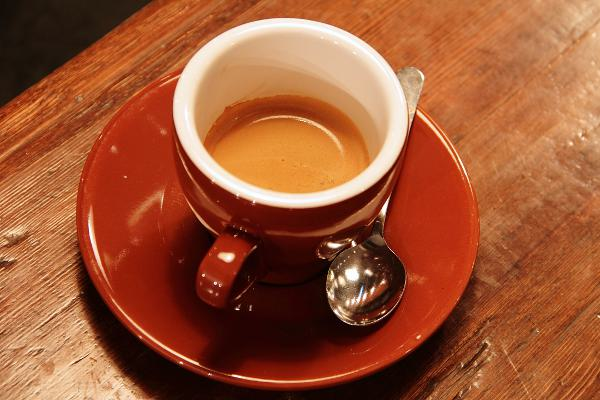

In [5]:
arr2img(i)

现在，创建简单的“图像编辑器”功能，允许对图像进行模糊处理或更改其色彩平衡：

In [6]:
def edit_image(image, sigma=0.1, R=1.0, G=1.0, B=1.0):
    new_image = filters.gaussian(image, sigma=sigma, channel_axis=-1)
    new_image[:,:,0] = R*new_image[:,:,0]
    new_image[:,:,1] = G*new_image[:,:,1]
    new_image[:,:,2] = B*new_image[:,:,2]
    return arr2img(new_image)

可以手动调用这个函数并获得一张新图像。例如，让我们稍微模糊一下图像并去除所有的红色：

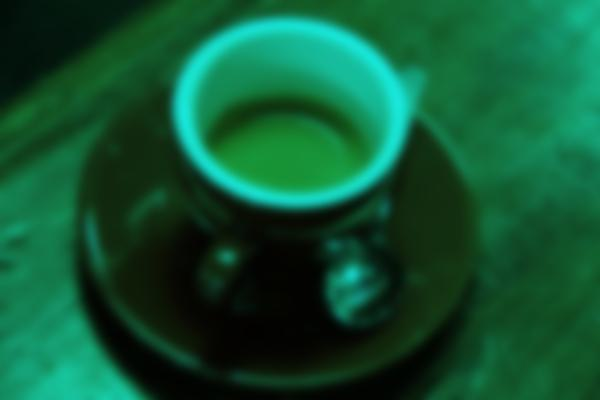

In [7]:
edit_image(i, sigma=5, R=0.1)

但是，通过交互式控制每个参数并立即获得视觉反馈来探索这个函数的作用要容易得多。IPython 的 `ipywidgets` 包让我们可以用最少的代码来实现这一点：

```python
lims = (0.0,1.0,0.01)
interact(edit_image, image=fixed(i), sigma=(0.0,10.0,0.1), R=lims, G=lims, B=lims);
```

## 浏览 `scikit-image` 图库，并编辑灰度和 `jpg` 图像

咖啡杯并不是随 `scikit-image` 一起提供的唯一图像，`data` 模块还有其他图像。让我们快速创建一个交互式浏览器来探索这些图像：

```python
def choose_img(name):
    # Let's store the result in the global `img` that we can then use in our image editor below
    global img
    img = getattr(data, name)()
    return arr2img(img)

# Skip 'load' and 'lena', two functions that don't actually return images
interact(choose_img, name=sorted(set(data.__all__)-{'lena', 'load'}));
```

现在，让我们更新我们的编辑器，以便正确处理灰度和彩色图像，因为 scikit-image 图库中的一些图像是灰度的。对于这些图像，我们忽略红色（R）和蓝色（B）通道，并将 'G' 视为 'Grayscale'：

```python
lims = (0.0, 1.0, 0.01)

def edit_image(image, sigma, R, G, B):
    new_image = filters.gaussian(image, sigma=sigma, channel_axis=-1)
    if new_image.ndim == 3:
        new_image[:,:,0] = R*new_image[:,:,0]
        new_image[:,:,1] = G*new_image[:,:,1]
        new_image[:,:,2] = B*new_image[:,:,2]
    else:
        new_image = G*new_image
    return arr2img(new_image)

interact(edit_image, image=fixed(img), sigma=(0.0, 10.0, 0.1), 
               R=lims, G=lims, B=lims);
```